Import relevant modules

In [80]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from xgboost import to_graphviz
from xgboost import plot_tree
from xgboost import Booster
from graphviz import Source
from pprint import pprint

Import the dataset

In [81]:
df = pd.read_csv("car_data.csv")
print(df.head())  # Shows the first 5 rows

   User ID Gender  Age  AnnualSalary  Purchased
0      385   Male   35         20000          0
1      681   Male   40         43500          0
2      353   Male   49         74000          0
3      895   Male   40        107500          1
4      661   Male   25         79000          0


In [51]:
# Count the number of rows in the original dataset
total_rows = df.shape[0]
print(f"Total rows in the original dataset: {total_rows}")

# Count the number of rows in the training set
train_rows = X_train.shape[0]
print(f"Rows in the training set: {train_rows}")

# Count the number of rows in the validation set
val_rows = X_val.shape[0]
print(f"Rows in the validation set: {val_rows}")

# Count the number of rows in the test set
test_rows = X_test.shape[0]
print(f"Rows in the test set: {test_rows}")


Total rows in the original dataset: 1000
Rows in the training set: 600
Rows in the validation set: 200
Rows in the test set: 200


**XGBoost Decision Tree generation**

Process an initial decision tree algorithm and assess its performance

In [82]:
# Preprocess the data: Encoding categorical features if necessary
# 'Gender' is categorical, we need to encode it into numeric values
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

# Features (X) and target (y)
X = df[['Age', 'AnnualSalary', 'Gender']]  # Features
y = df['Purchased']  # Target variable

# Split the data into training (60%), validation (20%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Initialize XGBoost model
model = xgb.XGBClassifier(eval_metric="logloss")

# Train model with eval set to track learning curves
eval_set = [(X_train, y_train), (X_val, y_val)]
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Make predictions on the training set, evaluate the model on the training set
y_train_pred = model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training set accuracy: {train_accuracy:.4f}")

# Make predictions on the validation set, evaluate the model on the validation set
y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_accuracy:.4f}")

# Make predictions on the test set, evaluate the model on the test set
y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy:.4f}")


Training set accuracy: 0.9883
Validation accuracy: 0.9050
Test accuracy: 0.8850


Output the parameters of the model

In [101]:
# the user-specified parameters
print("Effective user-specified XGBoost parameters:")
print(model.get_xgb_params())

Effective user-specified XGBoost parameters:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'eval_metric': 'logloss', 'gamma': None, 'grow_policy': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'monotone_constraints': None, 'multi_strategy': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [103]:
# Get full config of the trained booster (not just user-specified ones)
# Get and parse the config
config_str = model.get_booster().save_config()
config_dict = json.loads(config_str)

# Extract values
tree_params = config_dict['learner']['gradient_booster']['tree_train_param']
num_trees = int(config_dict['learner']['gradient_booster']['gbtree_model_param']['num_trees'])
max_depth = int(tree_params['max_depth'])
learning_rate = float(tree_params['learning_rate'])  # or 'eta', same value

# Print overall results
print("Effective XGBoost parameters:")
pprint(config)

# Print individual statements
print(f"\nmax_depth: {max_depth}")
print(f"learning_rate: {learning_rate}")
print(f"n_estimators (num_trees): {num_trees}")


Effective XGBoost parameters:
'{"learner":{"generic_param":{"device":"cpu","fail_on_invalid_gpu_id":"0","n_jobs":"0","nthread":"0","random_state":"0","seed":"0","seed_per_iteration":"0","validate_parameters":"1"},"gradient_booster":{"gbtree_model_param":{"num_parallel_tree":"1","num_trees":"100"},"gbtree_train_param":{"process_type":"default","tree_method":"auto","updater":"grow_quantile_histmaker","updater_seq":"grow_quantile_histmaker"},"name":"gbtree","specified_updater":false,"tree_train_param":{"alpha":"0","cache_opt":"1","colsample_bylevel":"1","colsample_bynode":"1","colsample_bytree":"1","eta":"0.300000012","gamma":"0","grow_policy":"depthwise","interaction_constraints":"","lambda":"1","learning_rate":"0.300000012","max_bin":"256","max_cat_threshold":"64","max_cat_to_onehot":"4","max_delta_step":"0","max_depth":"6","max_leaves":"0","min_child_weight":"1","min_split_loss":"0","monotone_constraints":"()","refresh_leaf":"1","reg_alpha":"0","reg_lambda":"1","sampling_method":"unifo

**Hyperparameter Tuning**

Perform hyperparameter tuning (e.g., grid search), and output the best hyperparameters found.

In [105]:
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'n_estimators': [50, 75, 100, 150]
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_grid, cv=4)
grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")


Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


**Revise the decision tree algorithm**

Train a second model with these new and improved hyperparameters

Compare the results to the original model and confirm it's validation and test performance is improved

In [106]:
# Train second model with the best hyperparameters
model_v2 = xgb.XGBClassifier(
    learning_rate=0.1,
    max_depth=3,
    n_estimators=50,
    eval_metric="logloss"
)

# Train with evaluation set for monitoring
eval_set_v2 = [(X_train, y_train), (X_val, y_val)]
model_v2.fit(X_train, y_train, eval_set=eval_set_v2, verbose=False)

# Evaluate on training set
y_train_pred_v2 = model_v2.predict(X_train)
train_acc_v2 = accuracy_score(y_train, y_train_pred_v2)

# Evaluate on validation set
y_val_pred_v2 = model_v2.predict(X_val)
val_acc_v2 = accuracy_score(y_val, y_val_pred_v2)

# Evaluate on test set
y_test_pred_v2 = model_v2.predict(X_test)
test_acc_v2 = accuracy_score(y_test, y_test_pred_v2)

# Print comparison of original and new model accuracies
print("\nAccuracy Comparison:")
print(f"{'Dataset':<12}{'Original':>12}{'Tuned':>12}")
print(f"{'Training':<12}{train_accuracy:>12.4f}{train_acc_v2:>12.4f}")
print(f"{'Validation':<12}{val_accuracy:>12.4f}{val_acc_v2:>12.4f}")
print(f"{'Test':<12}{test_accuracy:>12.4f}{test_acc_v2:>12.4f}")



Accuracy Comparison:
Dataset         Original       Tuned
Training          0.9883      0.9267
Validation        0.9050      0.9300
Test              0.8850      0.8850


Plot a graph to compare performance of the original model and the tuned model

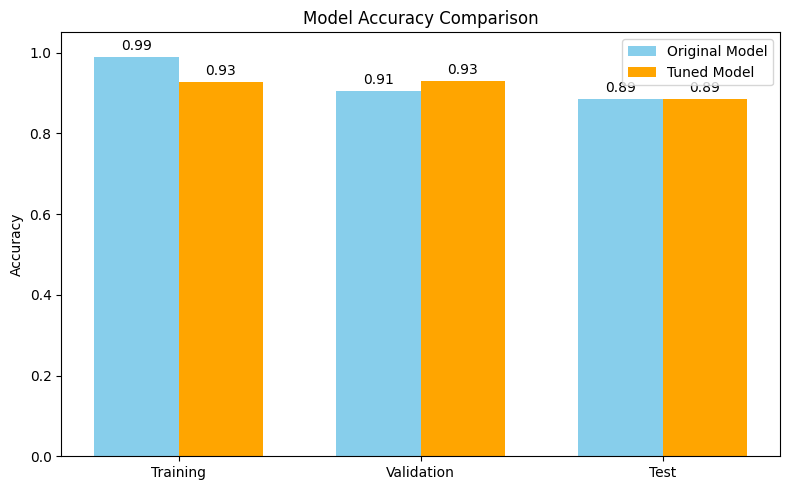

In [107]:
# Accuracy scores
datasets = ['Training', 'Validation', 'Test']
original_accuracies = [train_accuracy, val_accuracy, test_accuracy]
tuned_accuracies = [train_acc_v2, val_acc_v2, test_acc_v2]

# Bar width and positions
x = np.arange(len(datasets))
width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, original_accuracies, width, label='Original Model', color='skyblue')
bars2 = ax.bar(x + width/2, tuned_accuracies, width, label='Tuned Model', color='orange')

# Add labels and title
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(datasets)
ax.set_ylim(0, 1.05)
ax.legend()

# Display accuracy values on top of bars
for bar_group in [bars1, bars2]:
    for bar in bar_group:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()

**Summary of performance of revised model**

Feature Importance Plot: This plot shows how important each feature is in making decisions in the model. It's crucial for interpretability.

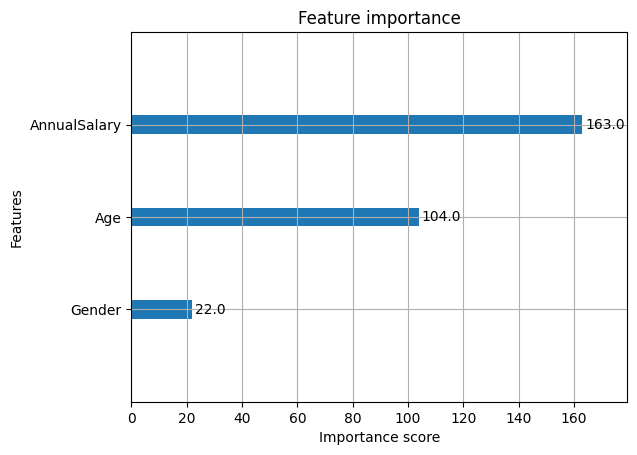

In [108]:
# Plot the feature importance
xgb.plot_importance(model_v2)
plt.show()

Output the misclassified examples from the test set

In [111]:
# Get boolean mask of misclassified examples
misclassified_mask = y_test != y_test_pred_v2

# Get the misclassified examples from X_train and y_train
misclassified_examples = X_test[misclassified_mask].copy()
misclassified_examples['Actual'] = y_test[misclassified_mask].values
misclassified_examples['Predicted'] = y_test_pred_v2[misclassified_mask]

# Decode Gender if needed (optional for readability)
misclassified_examples['Gender'] = le.inverse_transform(misclassified_examples['Gender'])

# Print the misclassified examples in a table
print("\nMisclassified Training Examples:")
print(misclassified_examples.to_string(index=False))



Misclassified Training Examples:
 Age  AnnualSalary Gender  Actual  Predicted
  27         96000 Female       1          0
  35        108000   Male       0          1
  45         22000   Male       1          0
  49         74000   Male       0          1
  45         26000   Male       1          0
  40         76500 Female       1          0
  35        116500   Male       0          1
  50         53500 Female       1          0
  47         42500 Female       1          0
  35         91000   Male       1          0
  44        134500 Female       0          1
  46         22000 Female       0          1
  46         80500   Male       0          1
  38         80500   Male       1          0
  40         81500   Male       1          0
  40         80500 Female       1          0
  48         52500 Female       1          0
  45         82500 Female       1          0
  62         44500 Female       0          1
  37         78000 Female       1          0
  51        134000 Fe

In [ ]:
Plot the tuned decision tree

<Figure size 2000x1000 with 0 Axes>

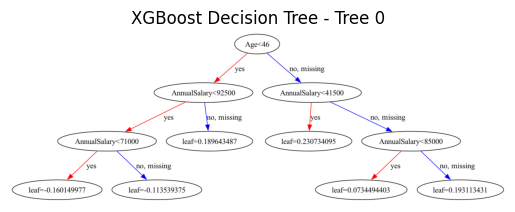

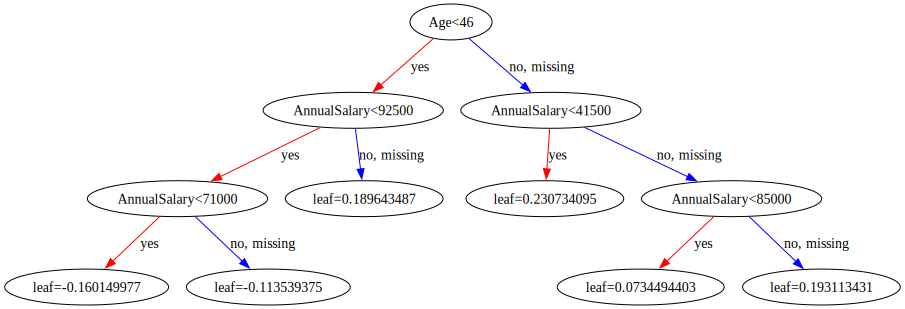

In [112]:
# Plot the first tree (index = 0) in the XGBoost model with title
plt.figure(figsize=(20, 10))  # Adjust size as needed
xgb.plot_tree(model_v2, tree_idx=0)
plt.title("XGBoost Decision Tree - Tree 0")
plt.show()

# Get the raw DOT data for the first tree
booster: Booster = model_v2.get_booster()
dot_data = booster.get_dump(dump_format='dot')[0]

# Render the DOT data as an interactive graph with graphviz
Source(dot_data)

<Figure size 2000x1000 with 0 Axes>

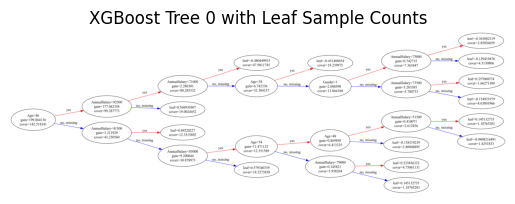

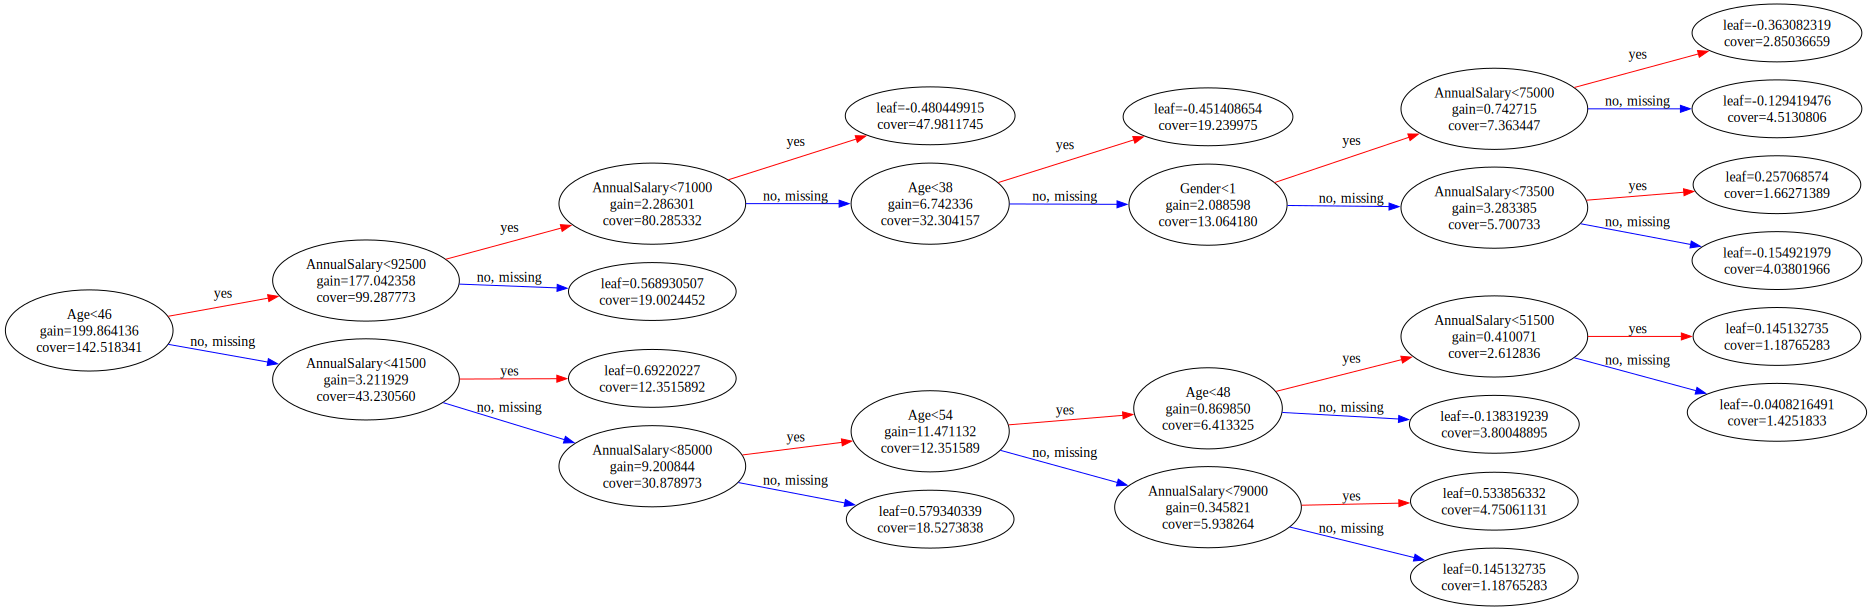

In [54]:
# Plot the first tree with statistics about leaf sample counts
plt.figure(figsize=(20, 10))
xgb.plot_tree(model, tree_idx=0, rankdir='LR', with_stats=True)
plt.title("XGBoost Tree 0 with Leaf Sample Counts")
plt.show()

# Create the Graphviz object for the first tree
dot = to_graphviz(model, tree_idx=0, rankdir='LR', with_stats=True)

# Display it 
dot  

Leaf: The predicted value for samples that end up in that leaf.

Cover: The total weight or number of samples that reach that leaf.

Gain: The improvement in model performance (reduction in impurity) due to the decision made at that node.

**Model Performance Metrics**

Accuracy: The percentage of correctly predicted instances out of the total predictions.

Precision, Recall, F1-score: These metrics are especially useful for imbalanced classes, where accuracy might not fully capture model performance.

Confusion Matrix: Displays the count of true positive, false positive, true negative, and false negative predictions.

In [114]:
# For validation set
print("Validation Accuracy: ", accuracy_score(y_val, y_val_pred_v2))
print("Classification Report (Validation Set):\n", classification_report(y_val, y_val_pred_v2))
print("Confusion Matrix (Validation Set):\n", confusion_matrix(y_val, y_val_pred_v2))

# For test set
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred_v2))
print("Classification Report (Test Set):\n", classification_report(y_test, y_test_pred_v2))
print("Confusion Matrix (Test Set):\n", confusion_matrix(y_test, y_test_pred_v2))


Validation Accuracy:  0.93
Classification Report (Validation Set):
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       111
           1       0.97      0.87      0.92        89

    accuracy                           0.93       200
   macro avg       0.94      0.92      0.93       200
weighted avg       0.93      0.93      0.93       200

Confusion Matrix (Validation Set):
 [[109   2]
 [ 12  77]]
Test Accuracy:  0.885
Classification Report (Test Set):
               precision    recall  f1-score   support

           0       0.89      0.93      0.91       120
           1       0.88      0.82      0.85        80

    accuracy                           0.89       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.89      0.88       200

Confusion Matrix (Test Set):
 [[111   9]
 [ 14  66]]


**Learning Curves**

Training and Validation Loss: Visualizing the loss during training helps to understand if the model is overfitting or underfitting.

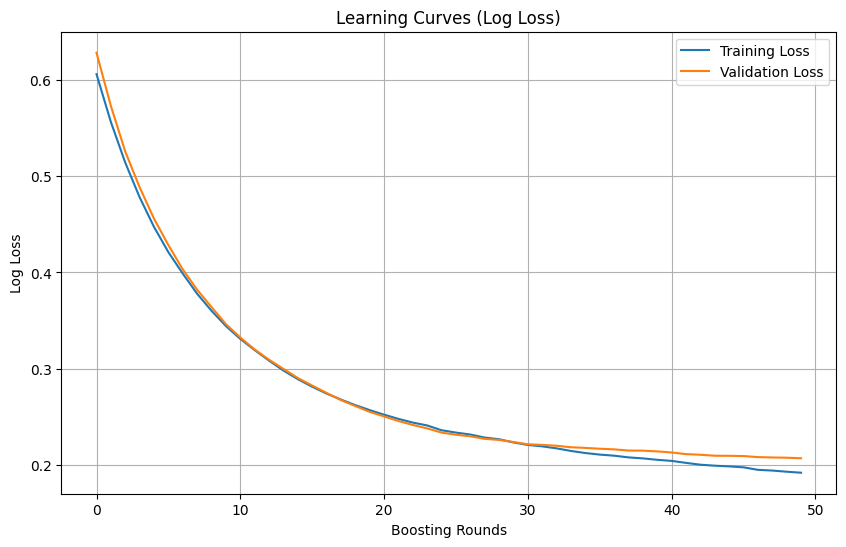

In [115]:
# Get and plot learning curves
results = model_v2.evals_result()

plt.figure(figsize=(10, 6))
plt.plot(results['validation_0']['logloss'], label='Training Loss')
plt.plot(results['validation_1']['logloss'], label='Validation Loss')
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("Learning Curves (Log Loss)")
plt.legend()
plt.grid(True)
plt.show()